In [174]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.pylab as plt_lab
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn import model_selection

from glob import glob
import cv2

import os

In [175]:
img_categories = os.listdir("realwaste-main/RealWaste")
img_categories = [c for c in img_categories if c[0] != '.']
img_categories

# get paths for all images in all categories
img_paths = {}
for cat in img_categories:
    img_paths[cat] = glob(f"realwaste-main/RealWaste/{cat}/*.jpg")

# get the number of images per category
img_counts = {}
for cat in img_categories:
    img_counts[cat] = len(img_paths[cat])
img_counts

# create df of image counts
img_counts_df = pd.DataFrame.from_dict(img_counts, orient='index', columns=["count"])
img_counts_df.reset_index(inplace=True, names="category")
img_counts_df

,category,count
0,Paper,500
1,Textile,318
2,Metal,790
3,Cardboard,461
4,Miscellaneous,495
5,Food Organics,411
6,Glass,420
7,Vegetation,436
8,Plastic,921


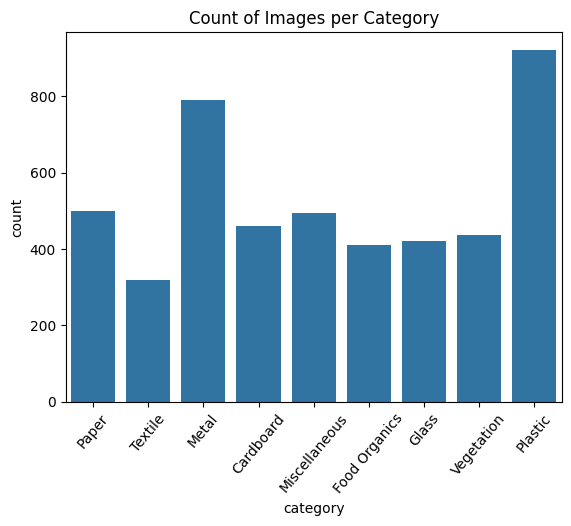

In [176]:
sns.barplot(img_counts_df, x="category", y="count")
plt.title("Count of Images per Category")
plt.xticks(rotation=50)
plt.show()

(524, 524, 3)

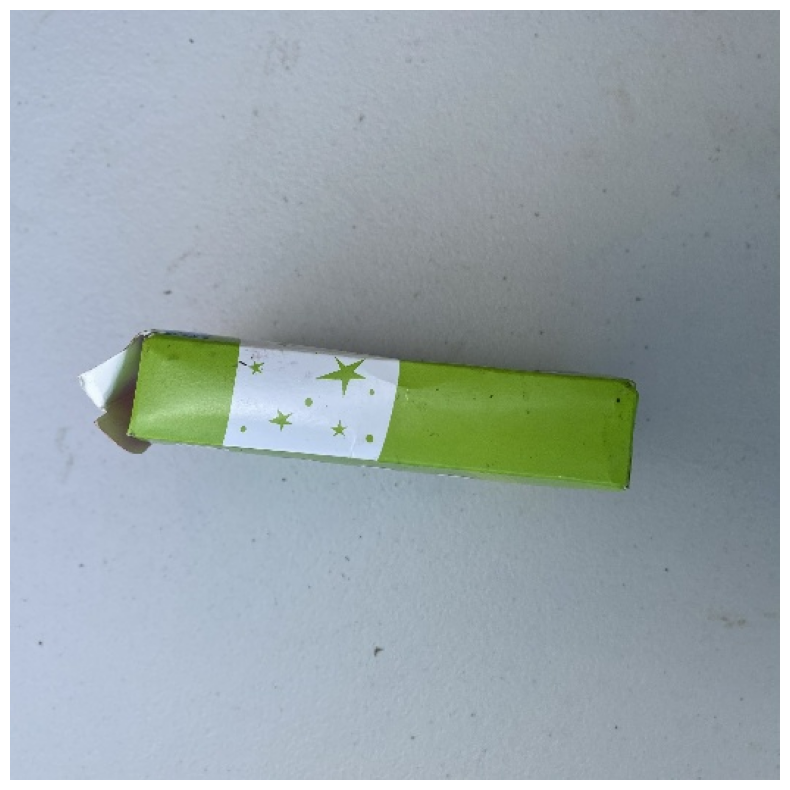

In [177]:
# extract first image from cardboard category
cardboard = img_paths['Cardboard']
img_mpl = plt.imread(cardboard[0])
display(img_mpl.shape)

# display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_mpl)
ax.axis('off')
plt.show()

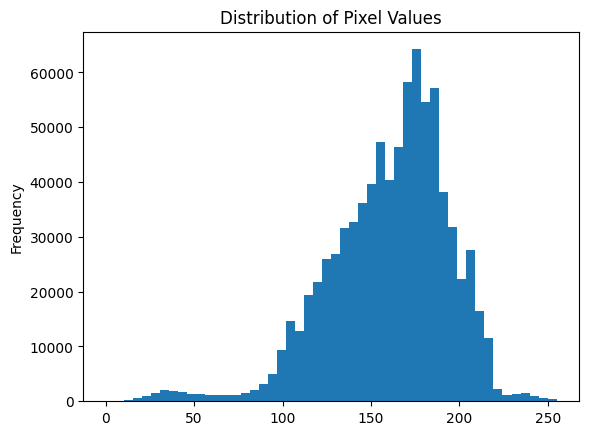

In [178]:
pd.Series(img_mpl.flatten()).plot(kind='hist', bins=50, title='Distribution of Pixel Values')
plt.show()

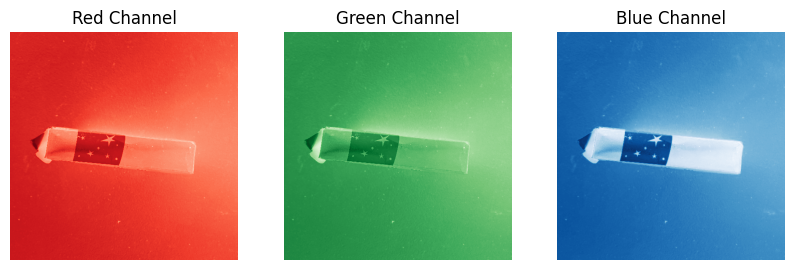

In [179]:
colors = ["Red", "Green", "Blue"]

# display the image in the 3 different color channels
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_mpl[:,:,i], cmap=colors[i]+"s")
    ax.axis('off')
    ax.set_title(colors[i] + " Channel")
plt.show()

In [180]:
# takes an image and extracts the average color value for the specified number of pixels, and returns a list of those averages. 
def img_color_avgs(img_color_data, num_values):
    img_color_avgs = []
    curr_bin_data = []

    for val in img_color_data:
        # calculate average if the number of values is the number of bins
        if len(curr_bin_data) == num_values:
            img_color_avgs.append(np.mean(curr_bin_data))
            curr_bin_data = []
        # append values to calculate average value for this bin
        else:
            curr_bin_data.append(val)

    return img_color_avgs

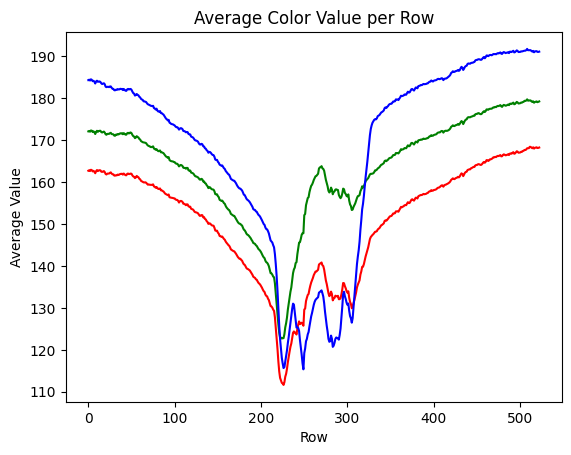

In [181]:
num_values = 524 # avg color value for each row

for i in range(len(colors)):
    img_color_data = pd.Series(img_mpl[:,:,i].flatten())
    img_avgs = img_color_avgs(img_color_data, num_values)
    
    sns.lineplot(data=img_avgs, color=colors[i])
    plt.title("Average Color Value per Row")
    plt.xlabel("Row")
    plt.ylabel("Average Value")
plt.show()

In [182]:
# avg rgb value per image & then per quadrant
# std deviation of rgb values per quadrant
# median & mode of rgb values per quadrant

# 1 csv file
# columns = avg_blue, std_blue, median_blue, mode_blue, avg_red, std_red, median_red, mode_red, avg_green, std_green, median_green, mode_green
# rows = each image

In [183]:
filter_maps = {
    "identity": np.array([[0, 0, 0],
                          [0, 1, 0],
                          [0, 0, 0]]),
    "edge_detection": np.array([[-1, -1, -1],
                          [-1, 8, -1],
                          [-1, -1, -1]])
}

In [184]:
# converts an image into a dictionary that contains statistics on the images color channels, using the given filter map
def get_image_info(img_path, filter_map=filter_maps["identity"]):
    colors = ["red", "green", "blue"]

    image_data = plt.imread(img_path)
    filtered_img_data = cv2.filter2D(image_data, -1, filter_map)
    category = img_path.split("/")[-1].split("_")[0]
    img_name = img_path.split("/")[-1]
    
    image_dict = {"category": category, "file_name": img_name}
    for i in range(len(colors)):
        img_color_data = pd.Series(filtered_img_data[:,:,i].flatten())
        
        image_dict[f"avg_{colors[i]}"] = np.mean(img_color_data)
        image_dict[f"std_{colors[i]}"] = np.std(img_color_data)
        image_dict[f"median_{colors[i]}"] = np.median(img_color_data)
        image_dict[f"mode_{colors[i]}"] = stats.mode(img_color_data).mode

    return image_dict

In [185]:
# converts the specified number of images in the given categories to a dictionary of color statistics using filter_map
def convert_images_to_dict(img_paths, categories, num_imgs_per_cat, filter_map):
    starttime = time.time()
    
    img_data = {}
    for cat in categories:
        for i in range(num_imgs_per_cat):
            path = img_paths[cat][i]
            
            img_dict = get_image_info(path, filter_map)
            
            for key in img_dict.keys():
                if key in img_data.keys():
                    img_data[key].append(img_dict[key])
                else:
                    img_data[key] = [img_dict[key]]
        print(f"Finished with {cat} images...")
        
    endtime = time.time()
    
    print(f"...Finished all categories, total time taken: {(endtime-starttime)/60} minutes")
    return img_data

In [188]:
# test conversion on 10 cardboard images

categories = ["Cardboard"]
num_imgs = 10

img_data = convert_images_to_dict(img_paths, categories, num_imgs, filter_maps["identity"])

Finished with Cardboard images...
...Finished all categories, total time taken: 0.008128801981608072 minutes


In [189]:
imgs_df = pd.DataFrame.from_dict(img_data)
imgs_df

,category,file_name,avg_red,std_red,median_red,mode_red,avg_green,std_green,median_green,mode_green,avg_blue,std_blue,median_blue,mode_blue
0,Cardboard,Cardboard_266.jpg,150.748558,27.252191,157.0,174,163.363018,26.701420,169.0,186,167.679539,43.266181,177.0,205
1,Cardboard,Cardboard_272.jpg,166.298824,40.186743,184.0,197,159.200251,62.512910,189.0,209,159.945035,72.077599,193.0,0
2,Cardboard,Cardboard_299.jpg,127.797306,50.839810,141.0,144,144.655425,48.568199,152.0,147,165.232045,51.108708,169.0,159
3,Cardboard,Cardboard_58.jpg,161.338274,39.549271,169.0,208,167.049589,41.897049,178.0,215,171.167844,46.409707,188.0,213
4,Cardboard,Cardboard_138.jpg,122.218442,46.053082,133.0,0,139.523356,40.306942,145.0,165,162.866277,44.405927,168.0,190
5,Cardboard,Cardboard_110.jpg,143.601243,53.596646,156.0,169,153.502131,56.039640,167.0,168,166.187150,59.877889,181.0,199
6,Cardboard,Cardboard_64.jpg,144.931917,61.296505,158.0,0,155.114322,53.704691,163.0,193,167.819070,44.623195,171.0,138
7,Cardboard,Cardboard_70.jpg,160.672375,36.161306,164.0,163,160.002586,35.472665,162.0,159,149.993528,35.718356,151.0,152
8,Cardboard,Cardboard_104.jpg,137.327971,40.004903,136.0,132,148.713489,42.264801,146.0,134,162.640872,46.811372,160.0,142
9,Cardboard,Cardboard_448.jpg,159.692493,37.744882,168.0,184,157.190563,49.658586,169.0,196,153.338598,65.930425,172.0,219


In [202]:
# converts all images in img_paths to a dictionary of color statistics using filter_map
def convert_all_images_to_dict(img_paths, filter_map):
    starttime = time.time()
    
    img_data = {}
    for cat in img_categories:
        for path in img_paths[cat]:
            img_dict = get_image_info(path, filter_map)
            for key in img_dict.keys():
                if key in img_data.keys():
                    img_data[key].append(img_dict[key])
                else:
                    img_data[key] = [img_dict[key]]
        print(f"Finished with {cat} images...")
        
    endtime = time.time()
    
    print(f"...Finished all categories, total time taken: {(endtime-starttime)/60} minutes")
    return img_data

In [203]:
img_data_raw = convert_all_images_to_dict(img_paths, filter_maps["identity"])

Finished with Paper images...
Finished with Textile images...
Finished with Metal images...
Finished with Cardboard images...
Finished with Miscellaneous images...
Finished with Food Organics images...
Finished with Glass images...
Finished with Vegetation images...
Finished with Plastic images...
...Finished all categories, total time taken: 3.6647743145624796 minutes


In [204]:
imgs_raw_df = pd.DataFrame.from_dict(img_data_raw)
imgs_raw_df

,category,file_name,avg_red,std_red,median_red,mode_red,avg_green,std_green,median_green,mode_green,avg_blue,std_blue,median_blue,mode_blue
0,Paper,Paper_259.jpg,157.115626,45.806933,173.0,185,156.961220,45.961089,173.0,179,151.197304,51.077498,168.0,188
1,Paper,Paper_265.jpg,153.717350,39.403260,160.0,162,149.548912,42.789022,157.0,157,141.960361,42.276008,145.0,144
2,Paper,Paper_271.jpg,156.283499,32.441637,160.0,163,156.781496,32.818887,159.0,159,152.885584,37.513639,156.0,163
3,Paper,Paper_488.jpg,144.649015,48.445898,152.0,189,149.063072,49.328850,156.0,141,142.839265,59.185788,147.0,119
4,Paper,Paper_339.jpg,157.764222,52.479338,175.0,193,157.025479,50.964438,174.0,191,150.889717,52.776513,167.0,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,Plastic,Plastic_548.jpg,141.591465,35.972357,145.0,142,152.019678,39.380274,155.0,184,164.758606,44.886508,169.0,211
4748,Plastic,Plastic_97.jpg,129.014309,24.338892,130.0,128,150.066091,26.855416,152.0,147,177.732500,33.470493,181.0,202
4749,Plastic,Plastic_789.jpg,163.531434,34.119195,166.0,172,164.809106,32.519198,166.0,160,159.861357,33.256643,160.0,146
4750,Plastic,Plastic_776.jpg,165.716596,21.798080,166.0,167,167.102718,22.546623,167.0,168,163.572257,24.503594,163.0,164


In [205]:
# save imgs_df as csv file
with open("img_data_raw.csv", "w") as img_file:
    img_file.write(imgs_raw_df.to_csv())

<Axes: xlabel='avg_red', ylabel='avg_blue'>

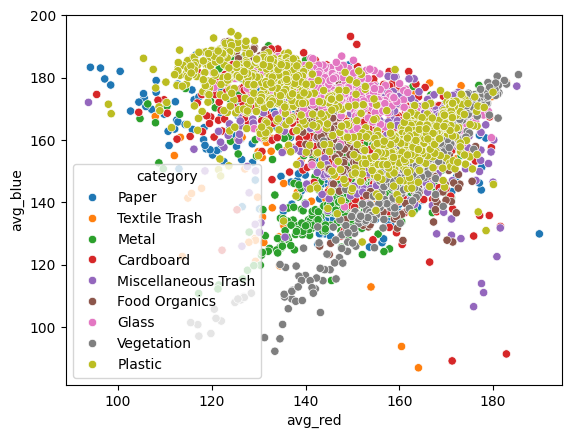

In [206]:
sns.scatterplot(data=imgs_df, x="avg_red", y="avg_blue", hue="category")

<Axes: xlabel='avg_red', ylabel='avg_green'>

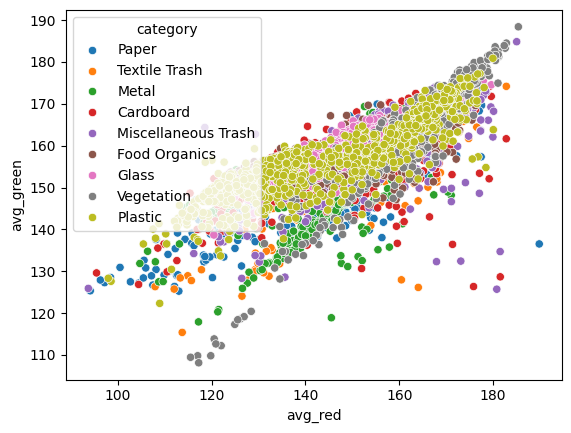

In [207]:
sns.scatterplot(data=imgs_df, x="avg_red", y="avg_green", hue="category")

<Axes: xlabel='avg_green', ylabel='avg_blue'>

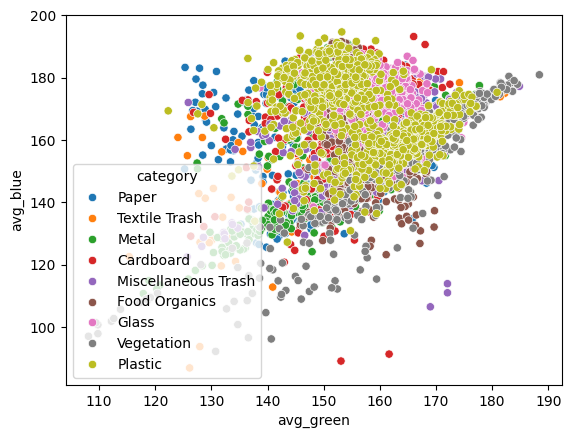

In [208]:
sns.scatterplot(data=imgs_df, x="avg_green", y="avg_blue", hue="category")

(524, 524, 3)


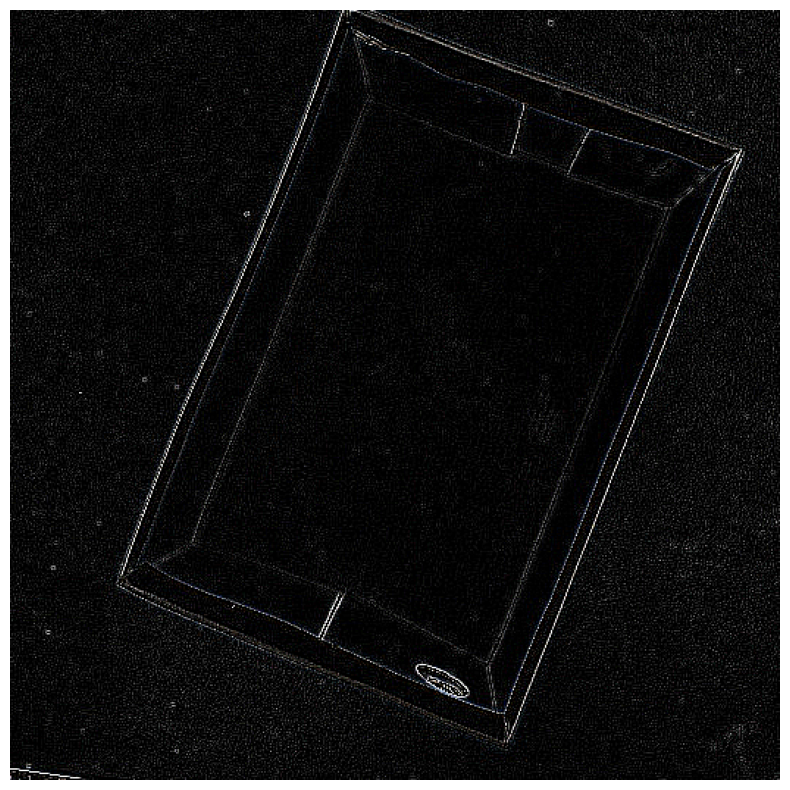

In [210]:
category = "Cardboard"
sample_img_path = img_paths[category][3]
sample_img = plt.imread(sample_img_path)
sample_img_edges = cv2.filter2D(sample_img, -1, filter_maps["edge_detection"])

print(sample_img_edges.shape)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sample_img_edges)
ax.axis('off')
plt.show()

In [211]:
num_imgs = 50

img_data_edges = convert_images_to_dict(img_paths, img_categories, num_imgs, filter_maps["edge_detection"])

img_data_edges_df = pd.DataFrame.from_dict(img_data_edges)
img_data_edges_df

Finished with Paper images...
Finished with Textile images...
Finished with Metal images...
Finished with Cardboard images...
Finished with Miscellaneous images...
Finished with Food Organics images...
Finished with Glass images...
Finished with Vegetation images...
Finished with Plastic images...
...Finished all categories, total time taken: 0.321709398428599 minutes


,category,file_name,avg_red,std_red,median_red,mode_red,avg_green,std_green,median_green,mode_green,avg_blue,std_blue,median_blue,mode_blue
0,Paper,Paper_259.jpg,23.079996,45.463581,0.0,0,23.082924,45.464838,0.0,0,23.113714,45.481520,0.0,0
1,Paper,Paper_265.jpg,14.488597,34.188327,0.0,0,14.542666,34.494860,0.0,0,14.534202,34.190056,0.0,0
2,Paper,Paper_271.jpg,14.211322,29.979259,0.0,0,14.206198,29.981140,0.0,0,14.280571,30.048304,0.0,0
3,Paper,Paper_488.jpg,29.176734,59.259465,1.0,0,29.186630,59.270644,1.0,0,29.384141,59.403160,1.0,0
4,Paper,Paper_339.jpg,31.914297,55.635209,0.0,0,31.910127,55.655675,0.0,0,32.049640,55.713222,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Plastic,Plastic_342.jpg,29.008078,46.663747,4.0,0,29.152548,46.978200,4.0,0,29.296049,47.131180,4.0,0
446,Plastic,Plastic_356.jpg,38.802499,56.254774,9.0,0,38.763417,56.126727,9.0,0,38.825899,56.144607,9.0,0
447,Plastic,Plastic_430.jpg,22.930995,39.221335,2.0,0,22.937176,39.208424,2.0,0,22.984795,39.275469,2.0,0
448,Plastic,Plastic_64.jpg,41.640897,59.050159,12.0,0,41.764440,59.014300,13.0,0,42.036434,59.103247,13.0,0


<Axes: xlabel='median_red', ylabel='std_red'>

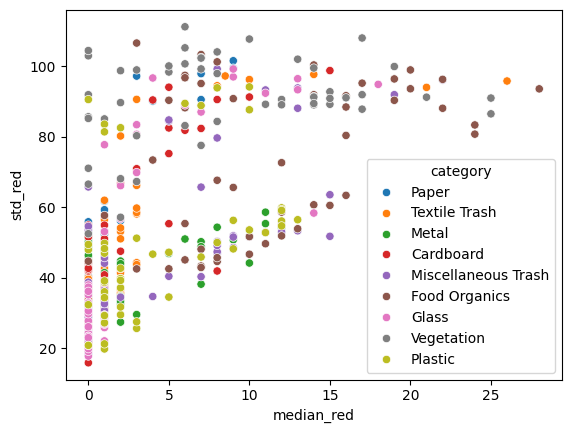

In [212]:
sns.scatterplot(data=img_data_edges_df, x="median_red", y="std_red", hue="category")

In [213]:
img_data_edges = convert_all_images_to_dict(img_paths, filter_maps["edge_detection"])

Finished with Paper images...
Finished with Textile images...
Finished with Metal images...
Finished with Cardboard images...
Finished with Miscellaneous images...
Finished with Food Organics images...
Finished with Glass images...
Finished with Vegetation images...
Finished with Plastic images...
...Finished all categories, total time taken: 3.4007082978884378 minutes


In [215]:
imgs_edges_df = pd.DataFrame.from_dict(img_data_edges)
imgs_edges_df

,category,file_name,avg_red,std_red,median_red,mode_red,avg_green,std_green,median_green,mode_green,avg_blue,std_blue,median_blue,mode_blue
0,Paper,Paper_259.jpg,23.079996,45.463581,0.0,0,23.082924,45.464838,0.0,0,23.113714,45.481520,0.0,0
1,Paper,Paper_265.jpg,14.488597,34.188327,0.0,0,14.542666,34.494860,0.0,0,14.534202,34.190056,0.0,0
2,Paper,Paper_271.jpg,14.211322,29.979259,0.0,0,14.206198,29.981140,0.0,0,14.280571,30.048304,0.0,0
3,Paper,Paper_488.jpg,29.176734,59.259465,1.0,0,29.186630,59.270644,1.0,0,29.384141,59.403160,1.0,0
4,Paper,Paper_339.jpg,31.914297,55.635209,0.0,0,31.910127,55.655675,0.0,0,32.049640,55.713222,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,Plastic,Plastic_548.jpg,33.754822,51.953449,9.0,0,33.811502,51.979191,9.0,0,33.967896,52.031709,9.0,0
4748,Plastic,Plastic_97.jpg,42.862330,60.216380,11.0,0,42.944292,60.204328,11.0,0,43.176512,60.239850,12.0,0
4749,Plastic,Plastic_789.jpg,68.182296,90.675204,6.0,0,68.172612,90.664885,6.0,0,68.224812,90.608222,6.0,0
4750,Plastic,Plastic_776.jpg,9.034297,16.606407,0.0,0,9.029675,16.590332,0.0,0,9.084782,16.647421,0.0,0


In [216]:
# save imgs_df as csv file
with open("img_data_edges.csv", "w") as img_file:
    img_file.write(imgs_edges_df.to_csv())